# Read the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
import warnings

%matplotlib inline

ratings = pd.read_table("http://www.tau.ac.il/~saharon/StatsLearn2018/train_ratings_all.dat", header = None)
miss_cong = pd.read_csv("http://www.tau.ac.il/~saharon/StatsLearn2018/train_y_rating.dat", header = None, names = ['score'])
movies = pd.read_csv("http://www.tau.ac.il/~saharon/StatsLearn2018/movie_titles.txt", header = None, names = ['year', 'title'])

# Peek at the data

In [2]:
print('no. of raters: %d, no. of movies: %d' % ratings.shape)
print('no. of miss_cong raters: %d, no. of movies: %d' % miss_cong.shape)
print()
print('first 4 movies, first 6 raters:')
print(ratings.values[:6, :4]) #notice ratings is still a pandas DataFrame, its `values` field is its numpy 2d array (matrix)
print()
print('head of movies DataFrame:')
print(movies.head())

no. of raters: 10000, no. of movies: 99
no. of miss_cong raters: 10000, no. of movies: 1

first 4 movies, first 6 raters:
[[2 4 4 4]
 [4 5 3 3]
 [5 5 5 5]
 [3 3 3 4]
 [4 4 4 5]
 [4 3 3 4]]

head of movies DataFrame:
   year                                              title
0  1996                                   Independence Day
1  2000                                        The Patriot
2  2004                             The Day After Tomorrow
3  2003  Pirates of the Caribbean: The Curse of the Bla...
4  1990                                       Pretty Woman


# Missing Data Exploration

## General

In [3]:
# putting None's for zeros
ratings[ratings == 0] = None

total_missing = np.sum(np.isnan(ratings.values))
total_obs = np.prod(ratings.shape)

print('total missing values: %d out of total observations: %d' % (total_missing, total_obs))
print('so that\'s %.2f missing' % (total_missing / total_obs))

total missing values: 152414 out of total observations: 990000
so that's 0.15 missing


## Marginal on Movies

In [4]:
# n missing per movie, adding it is another column of movies
missing_per_movie = np.isnan(ratings.values).sum(axis=0)
movies['n_missing'] = missing_per_movie

movies.head(20)

,year,title,n_missing
0,1996,Independence Day,0
1,2000,The Patriot,0
2,2004,The Day After Tomorrow,0
3,2003,Pirates of the Caribbean: The Curse of the Bla...,0
4,1990,Pretty Woman,0
5,1994,Forrest Gump,0
6,1999,The Green Mile,0
7,1997,Con Air,0
8,1996,Twister,0
9,2002,Sweet Home Alabama,0


In [5]:
# finding n missing of a specific movie
movies.loc[movies['title'] == 'American Beauty', 'n_missing']

19    2046
Name: n_missing, dtype: int64

In [6]:
# finding min, max, median and mean movie per n_missing, ignoring first 14 movies with no missing at all
movies_with_missing = movies.iloc[14:, :]

def get_val_of_col_by_col(df, by, col, value):
    idx = (np.abs(df[by] - value)).idxmin() # taking id *closest* to value because mean is involved
    return df.at[idx, col]

min_n_missing = np.min(movies_with_missing['n_missing'])
min_n_missing_movie = get_val_of_col_by_col(movies_with_missing, 'n_missing', 'title', min_n_missing)

max_n_missing = np.max(movies_with_missing['n_missing'])
max_n_missing_movie = get_val_of_col_by_col(movies_with_missing, 'n_missing', 'title', max_n_missing)

median_n_missing = np.median(movies_with_missing['n_missing'])
median_n_missing_movie = get_val_of_col_by_col(movies_with_missing, 'n_missing', 'title', median_n_missing)

mean_n_missing = np.mean(movies_with_missing['n_missing'])
mean_n_missing_movie = get_val_of_col_by_col(movies_with_missing, 'n_missing', 'title', mean_n_missing)

print('movie with minimum n missing: %s, with %d missing' % (min_n_missing_movie, min_n_missing))
print('movie with maximum n missing: %s, with %d missing' % (max_n_missing_movie, max_n_missing))
print('movie with median n missing: %s, with %d missing' % (median_n_missing_movie, median_n_missing))
print('movie with mean n missing: %s, with %d missing' % (mean_n_missing_movie, mean_n_missing))

movie with minimum n missing: Gladiator, with 722 missing
movie with maximum n missing: Sideways, with 4702 missing
movie with median n missing: A Few Good Men, with 1638 missing
movie with mean n missing: The Bourne Supremacy, with 1793 missing


/home/jonathansomer/.virtualenvs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


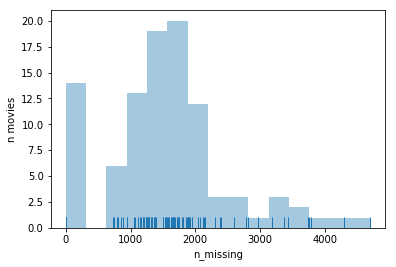

In [7]:
# histogram
sns.distplot(movies['n_missing'], kde=False, rug=True)
plt.ylabel('n movies')
plt.show()

## Marginal on Raters

In [8]:
# n missing per rater, creating a new DataFrame
raters = pd.DataFrame({'rater': range(ratings.shape[0])})
missing_per_rater = np.isnan(ratings.values).sum(axis=1)
raters['n_missing'] = missing_per_rater

raters.head(10)

,rater,n_missing
0,0,17
1,1,13
2,2,28
3,3,4
4,4,9
5,5,8
6,6,22
7,7,19
8,8,52
9,9,6


In [9]:
# finding min, max, median and mean rater per n_missing
min_n_missing = np.min(raters['n_missing'])
min_n_missing_rater = get_val_of_col_by_col(raters, 'n_missing', 'rater', min_n_missing)

max_n_missing = np.max(raters['n_missing'])
max_n_missing_rater = get_val_of_col_by_col(raters, 'n_missing', 'rater', max_n_missing)

median_n_missing = np.median(raters['n_missing'])
median_n_missing_rater = get_val_of_col_by_col(raters, 'n_missing', 'rater', median_n_missing)

mean_n_missing = np.mean(raters['n_missing'])
mean_n_missing_rater = get_val_of_col_by_col(raters, 'n_missing', 'rater', mean_n_missing)

print('rater with minimum n missing: %s, with %d missing' % (min_n_missing_rater, min_n_missing))
print('rater with maximum n missing: %s, with %d missing' % (max_n_missing_rater, max_n_missing))
print('rater with median n missing: %s, with %d missing' % (median_n_missing_rater, median_n_missing))
print('rater with mean n missing: %s, with %d missing' % (mean_n_missing_rater, mean_n_missing))

rater with minimum n missing: 81, with 0 missing
rater with maximum n missing: 7007, with 71 missing
rater with median n missing: 1, with 13 missing
rater with mean n missing: 21, with 15 missing


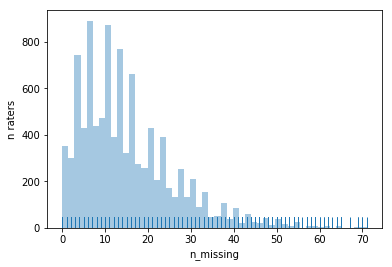

In [10]:
# histogram
sns.distplot(raters['n_missing'], kde=False, rug=True)
plt.ylabel('n raters')
plt.show()

# Scores Exploration (ignoring missing values)

## General

In [11]:
# min, max, median, mean:
print('min movies score: %.2f' % np.nanmin(ratings.values))
print('max movies score: %.2f' % np.nanmax(ratings.values))
print('median movies score: %.2f' % np.nanmedian(ratings.values))
print('mean movies score: %.2f' % np.nanmean(ratings.values))

min movies score: 1.00
max movies score: 5.00
median movies score: 4.00
mean movies score: 3.93


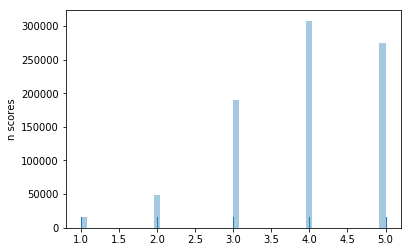

In [12]:
# histogram (barchart really)
sns.distplot(ratings.values[~np.isnan(ratings.values)], kde=False, rug=True)
plt.ylabel('n scores')
plt.show()

## Mean Scores, Marginal on Movies

In [13]:
# mean score per movie, adding it is another column of movies
mean_score_per_movie = np.nanmean(ratings.values, axis=0)
movies['mean_score'] = mean_score_per_movie

movies.head(10)

,year,title,n_missing,mean_score
0,1996,Independence Day,0,4.1463
1,2000,The Patriot,0,4.1073
2,2004,The Day After Tomorrow,0,3.7045
3,2003,Pirates of the Caribbean: The Curse of the Bla...,0,4.3482
4,1990,Pretty Woman,0,4.0748
5,1994,Forrest Gump,0,4.5143
6,1999,The Green Mile,0,4.4563
7,1997,Con Air,0,3.7287
8,1996,Twister,0,3.7546
9,2002,Sweet Home Alabama,0,3.6749


In [14]:
# finding min, max, median and mean movie per mean_score
min_mean_score = np.min(movies['mean_score'])
min_mean_score_movie = get_val_of_col_by_col(movies, 'mean_score', 'title', min_mean_score)

max_mean_score = np.max(movies['mean_score'])
max_mean_score_movie = get_val_of_col_by_col(movies, 'mean_score', 'title', max_mean_score)

median_mean_score = np.median(movies['mean_score'])
median_mean_score_movie = get_val_of_col_by_col(movies, 'mean_score', 'title', median_mean_score)

mean_mean_score = np.mean(movies['mean_score'])
mean_mean_score_movie = get_val_of_col_by_col(movies, 'mean_score', 'title', mean_mean_score)

print('movie with minimum mean score: %s, with mean %.2f' % (min_mean_score_movie, min_mean_score))
print('movie with maximum mean score: %s, with mean %.2f' % (max_mean_score_movie, max_mean_score))
print('movie with median mean score: %s, with mean %.2f' % (median_mean_score_movie, median_mean_score))
print('movie with mean mean score: %s, with mean %.2f' % (mean_mean_score_movie, mean_mean_score))

movie with minimum mean score: The Royal Tenenbaums, with mean 2.73
movie with maximum mean score: The Shawshank Redemption Special Edition, with mean 4.63
movie with median mean score: Air Force One, with mean 3.91
movie with mean mean score: American Pie, with mean 3.91


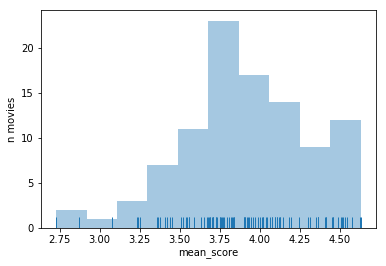

In [15]:
# histogram
sns.distplot(movies['mean_score'], kde=False, rug=True)
plt.ylabel('n movies')
plt.show()

## Mean Scores, Marginal on Raters

In [16]:
# mean score per rater, adding it is another column of raters
mean_score_per_rater = np.nanmean(ratings.values, axis=1)
raters['mean_score'] = mean_score_per_rater

raters.head(10)

,rater,n_missing,mean_score
0,0,17,3.792683
1,1,13,2.895349
2,2,28,4.901408
3,3,4,3.736842
4,4,9,3.833333
5,5,8,3.582418
6,6,22,4.688312
7,7,19,4.287500
8,8,52,4.170213
9,9,6,3.903226


In [17]:
# finding min, max, median and mean rater per mean_score
min_mean_score = np.min(raters['mean_score'])
min_mean_score_rater = get_val_of_col_by_col(raters, 'mean_score', 'rater', min_mean_score)

max_mean_score = np.max(raters['mean_score'])
max_mean_score_rater = get_val_of_col_by_col(raters, 'mean_score', 'rater', max_mean_score)

median_mean_score = np.median(raters['mean_score'])
median_mean_score_rater = get_val_of_col_by_col(raters, 'mean_score', 'rater', median_mean_score)

mean_mean_score = np.mean(raters['mean_score'])
mean_mean_score_rater = get_val_of_col_by_col(raters, 'mean_score', 'rater', mean_mean_score)

print('rater with minimum mean score: %s, with mean %.2f' % (min_mean_score_rater, min_mean_score))
print('rater with maximum mean score: %s, with mean %.2f' % (max_mean_score_rater, max_mean_score))
print('rater with median mean score: %s, with mean %.2f' % (median_mean_score_rater, median_mean_score))
print('rater with mean mean score: %s, with mean %.2f' % (mean_mean_score_rater, mean_mean_score))

rater with minimum mean score: 3961, with mean 2.04
rater with maximum mean score: 957, with mean 5.00
rater with median mean score: 7404, with mean 3.93
rater with mean mean score: 857, with mean 3.93


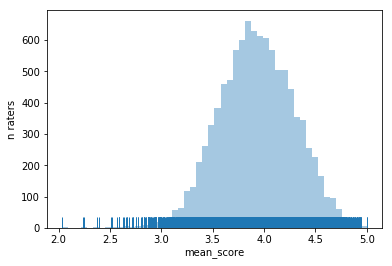

In [18]:
# histogram
sns.distplot(raters['mean_score'], kde=False, rug=True)
plt.ylabel('n raters')
plt.show()

## Mean Scores, Marginal on Release Year

**Warning**: a lot of pandas magic ahead.

In [19]:
# first, "attach" year to ratings:
ratings_by_year = ratings.T # transpose
ratings_by_year['year'] = movies['year'] # add new column
ratings_by_year.head(10)

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,year
0,2.0,4.0,5.0,3.0,4.0,4.0,5.0,3.0,5.0,4.0,...,4.0,4.0,4.0,4.0,5.0,3.0,4.0,4.0,2.0,1996
1,4.0,5.0,5.0,3.0,4.0,3.0,4.0,5.0,5.0,4.0,...,3.0,5.0,5.0,2.0,5.0,3.0,5.0,4.0,4.0,2000
2,4.0,3.0,5.0,3.0,4.0,3.0,5.0,3.0,5.0,4.0,...,3.0,5.0,4.0,2.0,5.0,3.0,3.0,4.0,2.0,2004
3,4.0,3.0,5.0,4.0,5.0,4.0,5.0,4.0,5.0,4.0,...,4.0,4.0,5.0,2.0,5.0,3.0,5.0,4.0,4.0,2003
4,5.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,5.0,5.0,...,5.0,5.0,5.0,4.0,5.0,5.0,3.0,2.0,4.0,1990
5,3.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,4.0,...,5.0,5.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,1994
6,4.0,3.0,5.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,...,5.0,5.0,5.0,3.0,5.0,4.0,4.0,3.0,3.0,1999
7,2.0,2.0,5.0,3.0,4.0,4.0,5.0,3.0,5.0,4.0,...,4.0,5.0,3.0,5.0,5.0,1.0,4.0,3.0,3.0,1997
8,3.0,3.0,5.0,3.0,4.0,3.0,5.0,2.0,5.0,4.0,...,2.0,5.0,4.0,5.0,5.0,3.0,3.0,2.0,5.0,1996
9,4.0,3.0,5.0,4.0,4.0,3.0,5.0,5.0,4.0,3.0,...,2.0,5.0,4.0,3.0,5.0,3.0,3.0,3.0,4.0,2002


In [20]:
# Then, "melt" DataFrame, so each year will have each score in a separate line
ratings_by_year = pd.melt(ratings_by_year, id_vars=['year'], value_vars=list(range(99)))
ratings_by_year.columns = ['year', 'movie_id', 'score']
ratings_by_year.head()

,year,movie_id,score
0,1996,0,2.0
1,2000,0,4.0
2,2004,0,4.0
3,2003,0,4.0
4,1990,0,5.0


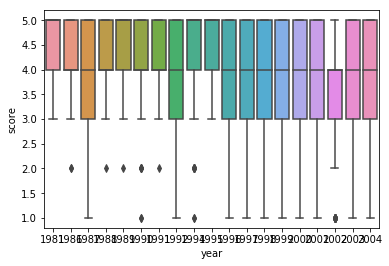

In [21]:
# boxplots are problematic on a 1 to 5 scale...
sns.boxplot('year', 'score', data = ratings_by_year)
plt.show()

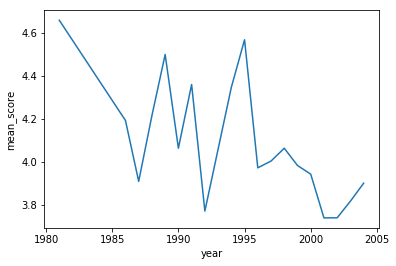

In [22]:
# so we can get mean score per year and use a simple line chart
ratings_by_year = ratings_by_year.groupby('year')['score'].mean().reset_index()
ratings_by_year.columns = ['year', 'mean_score']
sns.lineplot('year', 'mean_score', data = ratings_by_year)
plt.show()

# Pairwise Correlations

## General

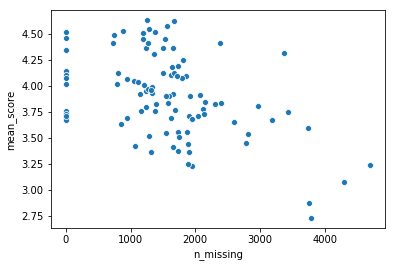

Pearson r correlation: -0.44


In [23]:
# is a movie "missingness" correlated with its mean score?
sns.scatterplot('n_missing', 'mean_score', data = movies)
plt.show()

print('Pearson r correlation: %.2f' % pearsonr(movies['n_missing'], movies['mean_score'])[0])

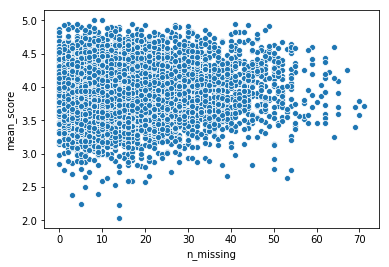

Pearson r correlation: 0.04


In [24]:
# is a rater's "missingness" correlated with her mean score?
sns.scatterplot('n_missing', 'mean_score', data = raters)
plt.show()

print('Pearson r correlation: %.2f' % pearsonr(raters['n_missing'], raters['mean_score'])[0])

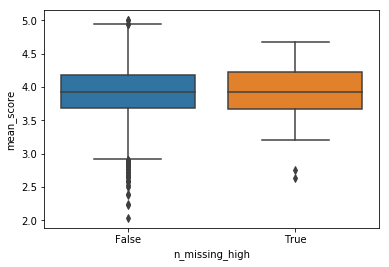

In [29]:
# it looked to me like with very high "missingness" the mean score is lower, but:
raters['n_missing_high'] = raters['n_missing'] > 50
sns.boxplot('n_missing_high', 'mean_score', data = raters)
plt.show()

## Marginal on Movies

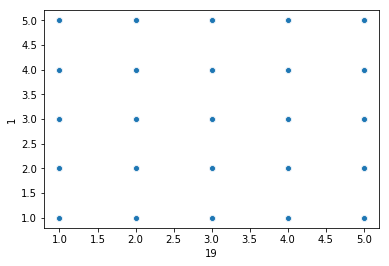

In [30]:
# look at a scatterplot of two specific movies, ignoring missing observations
def scatter_movies(mov1, mov2):
    mov1_id = movies.index[movies['title'] == mov1][0]
    mov2_id = movies.index[movies['title'] == mov2][0]
    sns.scatterplot(mov1_id, mov2_id, data = ratings)
    plt.show()
    
scatter_movies('American Beauty', 'The Patriot')

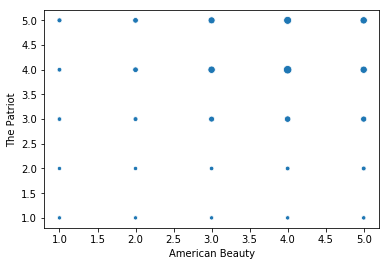

In [31]:
# oops, either use boxplots or make dots diameter proportional to group's size
def scatter_movies(mov1, mov2):
    mov1_id = movies.index[movies['title'] == mov1][0]
    mov2_id = movies.index[movies['title'] == mov2][0]
    mov1_scores = ratings.values[:, mov1_id]
    mov2_scores = ratings.values[:, mov2_id]
    nas = np.logical_or(np.isnan(mov1_scores), np.isnan(mov2_scores))
    agg_data = pd.DataFrame({'mov1': mov1_scores[~nas], 'mov2': mov2_scores[~nas]}).groupby(['mov1', 'mov2']).size().reset_index()
    agg_data.columns = [mov1, mov2, 'count']
    sns.scatterplot(mov1, mov2, size = 'count', data = agg_data, legend = False)
    plt.show()
scatter_movies('American Beauty', 'The Patriot')

In [32]:
# look at correlation of two specific movies
def corr_movies(mov1, mov2):
    mov1_id = movies.index[movies['title'] == mov1][0]
    mov2_id = movies.index[movies['title'] == mov2][0]
    mov1_scores = ratings.values[:, mov1_id]
    mov2_scores = ratings.values[:, mov2_id]
    nas = np.logical_or(np.isnan(mov1_scores), np.isnan(mov2_scores))
    return pearsonr(mov1_scores[~nas], mov2_scores[~nas])[0]

corr_movies('American Beauty', 'The Patriot')

-0.04850299965468798

In [33]:
# get all movies 99 * (99 - 1) / 2 pairwise correlations
movies_titles = movies['title'].values
pair_counter = 0
pair_corrs = dict()
for i in range(len(movies_titles) - 1):
    for j in range(i + 1, len(movies_titles)):
        mov1 = movies_titles[i]
        mov2 = movies_titles[j]
        pair_corrs[pair_counter] = {'mov1': mov1, 'mov2': mov2, 'corr': corr_movies(mov1, mov2)}
        pair_counter += 1
pair_corrs_df = pd.DataFrame.from_dict(pair_corrs, 'index')
pair_corrs_df.head(10)

,mov1,mov2,corr
0,Independence Day,The Patriot,0.247979
1,Independence Day,The Day After Tomorrow,0.306479
2,Independence Day,Pirates of the Caribbean: The Curse of the Bla...,0.196642
3,Independence Day,Pretty Woman,0.182783
4,Independence Day,Forrest Gump,0.147100
5,Independence Day,The Green Mile,0.189265
6,Independence Day,Con Air,0.321706
7,Independence Day,Twister,0.378102
8,Independence Day,Sweet Home Alabama,0.194208
9,Independence Day,Pearl Harbor,0.258672


In [34]:
# pair of movies with highest correlation:
max_corr_pair_id = pair_corrs_df['corr'].idxmax()
max_pair = pair_corrs_df.iloc[max_corr_pair_id, :].values.tolist()
print('movie1: %s, movie2: %s, correlation: %.2f' % (max_pair[0], max_pair[1], max_pair[2]))

movie1: Lord of the Rings: The Two Towers, movie2: Lord of the Rings: The Fellowship of the Ring, correlation: 0.80


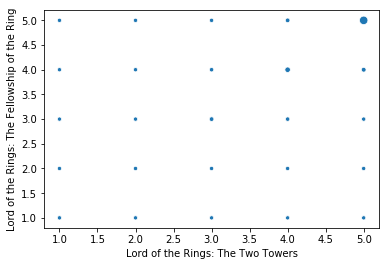

In [35]:
# see how the scatterplot of these raters look like
scatter_movies(max_pair[0], max_pair[1])

In [36]:
# pair of movies with lowest correlation:
min_corr_pair_id = pair_corrs_df['corr'].idxmin()
min_pair = pair_corrs_df.iloc[min_corr_pair_id, :].values.tolist()
print('movie1: %s, movie2: %s, correlation: %.2f' % (min_pair[0], min_pair[1], min_pair[2]))

movie1: Pearl Harbor, movie2: The Royal Tenenbaums, correlation: -0.17


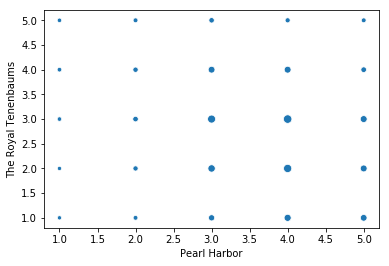

In [37]:
# see how the scatterplot of these movies look like
scatter_movies(min_pair[0], min_pair[1])

But beware: what would be the correlation between two movies all 10K raters chose to give a perfect rating?

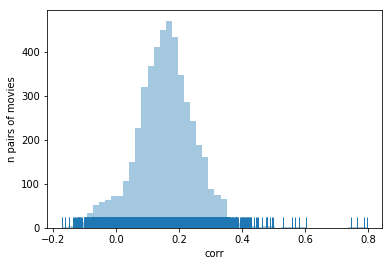

In [38]:
# histogram
sns.distplot(pair_corrs_df['corr'], kde=False, rug=True)
plt.ylabel('n pairs of movies')
plt.show()

# Marginal on Raters

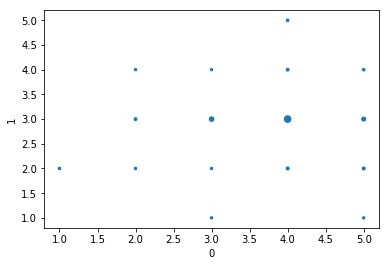

In [39]:
# look at a scatterplot of two specific raters, ignoring missing observations, making marker diameter proportional to group size
def scatter_raters(rater1, rater2):
    rater1_scores = ratings.values[rater1, :]
    rater2_scores = ratings.values[rater2, :]
    nas = np.logical_or(np.isnan(rater1_scores), np.isnan(rater2_scores))
    agg_data = pd.DataFrame({'rater1': rater1_scores[~nas], 'rater2': rater2_scores[~nas]}).groupby(['rater1', 'rater2']).size().reset_index()
    agg_data.columns = [rater1, rater2, 'count']
    sns.scatterplot(rater1, rater2, size = 'count', data = agg_data, legend = False)
    plt.show()
scatter_raters(0, 1)

In [40]:
# look at correlation of two specific raters
def corr_raters(rater1, rater2):
    rater1_scores = ratings.values[rater1, :]
    rater2_scores = ratings.values[rater2, :]
    nas = np.logical_or(np.isnan(rater1_scores), np.isnan(rater2_scores))
    return pearsonr(rater1_scores[~nas], rater2_scores[~nas])[0]

corr_raters(0, 1)

0.06245887897166847

In [41]:
# now, looking at all 10K * (10K - 1) / 2 pairwise correlations is time consuming, let's sample 10K *pairs* of raters
n = 10000
pair_corrs = dict()
for i in range(n):
    rater1, rater2 = np.random.choice(range(raters.shape[0]), 2, replace = False)
    pair_corrs[i] = {'rater1': rater1, 'rater2': rater2, 'corr': corr_raters(rater1, rater2)}
pair_corrs_df = pd.DataFrame.from_dict(pair_corrs, 'index')
pair_corrs_df.head(10)

/home/jonathansomer/.virtualenvs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


,rater1,rater2,corr
0,3046,5508,0.023005
1,7706,1918,0.263178
2,6497,9846,0.082903
3,3770,7636,0.140471
4,4476,2830,-0.093497
5,3901,6210,0.169219
6,8958,1498,0.267828
7,2833,9767,0.073357
8,950,9695,0.124434
9,5802,6956,0.196577


In [42]:
# here more likely to get missing values (why?)
sum(np.isnan(pair_corrs_df['corr']))

5

In [43]:
# pair of raters with highest correlation:
max_corr_pair_id = pair_corrs_df['corr'].idxmax()
max_pair = pair_corrs_df.iloc[max_corr_pair_id, :].values.tolist()
print('rater1: %s, rater2: %s, correlation: %.2f' % (max_pair[0], max_pair[1], max_pair[2]))

rater1: 1382.0, rater2: 4822.0, correlation: 0.74


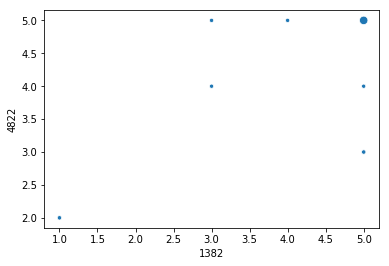

In [44]:
# see how the scatterplot of these raters look like
scatter_raters(int(max_pair[0]), int(max_pair[1]))

In [45]:
# pair of movies with lowest correlation:
min_corr_pair_id = pair_corrs_df['corr'].idxmin()
min_pair = pair_corrs_df.iloc[min_corr_pair_id, :].values.tolist()
print('rater1: %s, rater2: %s, correlation: %.2f' % (min_pair[0], min_pair[1], min_pair[2]))

rater1: 7793.0, rater2: 3250.0, correlation: -0.47


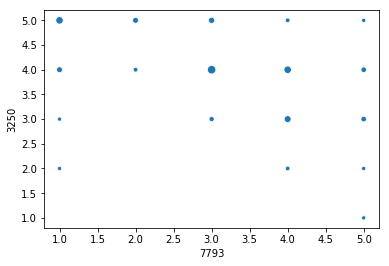

In [46]:
# see how the scatterplot of these raters look like
scatter_raters(int(min_pair[0]), int(min_pair[1]))

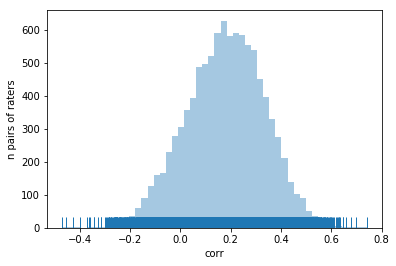

In [47]:
# histogram
pair_corrs_no_nans = pair_corrs_df['corr'][~np.isnan(pair_corrs_df['corr'])]
sns.distplot(pair_corrs_no_nans, kde=False, rug=True)
plt.ylabel('n pairs of raters')
plt.show()

# Correlation with Miss Congeniality

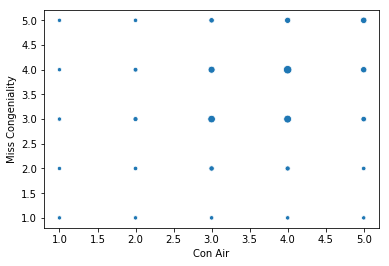

In [48]:
miss_cong_scores = miss_cong['score'].values

# see scatterplot of miss congeniality against another specific movie
def scatter_miss_cong(mov1):
    mov1_id = movies.index[movies['title'] == mov1][0]
    mov1_scores = ratings.values[:, mov1_id]
    nas = np.logical_or(np.isnan(mov1_scores), np.isnan(miss_cong_scores))
    agg_data = pd.DataFrame({'mov1': mov1_scores[~nas], 'mov2': miss_cong_scores[~nas]}).groupby(['mov1', 'mov2']).size().reset_index()
    agg_data.columns = [mov1, 'Miss Congeniality', 'count']
    sns.scatterplot(mov1, 'Miss Congeniality', size = 'count', data = agg_data, legend = False)
    plt.show()
scatter_miss_cong('Con Air')

In [49]:
# look at correlation of miss congeniality against another specific movie
def corr_miss_cong(mov1):
    mov1_id = movies.index[movies['title'] == mov1][0]
    mov1_scores = ratings.values[:, mov1_id]
    nas = np.logical_or(np.isnan(mov1_scores), np.isnan(miss_cong_scores))
    return pearsonr(mov1_scores[~nas], miss_cong_scores[~nas])[0]

corr_miss_cong('Con Air')

0.26409257070749775

In [50]:
# all Miss Congeniality's correlations with other movies
miss_cong_corrs = dict()
for i, mov1 in enumerate(movies_titles):
    miss_cong_corrs[i] = {'mov1': mov1, 'corr': corr_miss_cong(mov1)}
miss_cong_corrs_df = pd.DataFrame.from_dict(miss_cong_corrs, 'index')
miss_cong_corrs_df.head(10)

,mov1,corr
0,Independence Day,0.241628
1,The Patriot,0.177594
2,The Day After Tomorrow,0.258913
3,Pirates of the Caribbean: The Curse of the Bla...,0.184226
4,Pretty Woman,0.332299
5,Forrest Gump,0.057058
6,The Green Mile,0.157233
7,Con Air,0.264093
8,Twister,0.293391
9,Sweet Home Alabama,0.412030


In [51]:
# movie with highest correlation to Miss Congeniality:
max_corr_id = miss_cong_corrs_df['corr'].idxmax()
max_movie = miss_cong_corrs_df.iloc[max_corr_id, :].values.tolist()
print('movie with max corr to Miss congeniality: %s, correlation: %.2f' % (max_movie[0], max_movie[1]))

movie with max corr to Miss congeniality: The Wedding Planner, correlation: 0.43


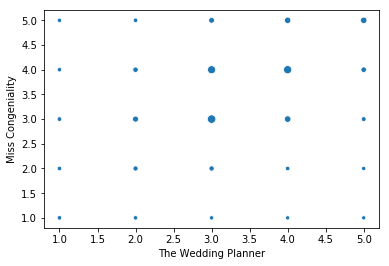

In [52]:
# see how the scatterplot looks like
scatter_miss_cong(max_movie[0])

In [53]:
# movie with lowest correlation to Miss Congeniality:
min_corr_id = miss_cong_corrs_df['corr'].idxmin()
min_movie = miss_cong_corrs_df.iloc[min_corr_id, :].values.tolist()
print('movie with min corr to Miss congeniality: %s, correlation: %.2f' % (min_movie[0], min_movie[1]))

movie with min corr to Miss congeniality: Pulp Fiction, correlation: -0.14


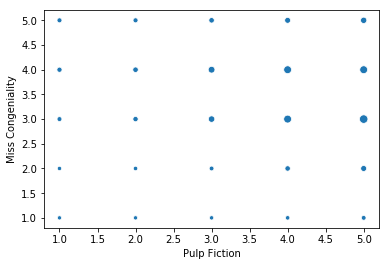

In [54]:
# see how the scatterplot looks like
scatter_miss_cong(min_movie[0])

# Miss Congeniality Conditional Distributions

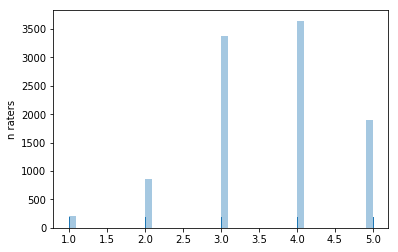

Miss Congeniality mean score is: 3.61


In [55]:
# first how does the marginal distirbution of Miss Congeniality look like?
sns.distplot(miss_cong_scores, kde=False, rug=True)
plt.ylabel('n raters')
plt.show()
print('Miss Congeniality mean score is: %.2f' % np.mean(miss_cong_scores))

## Conditional on Score

/home/jonathansomer/.virtualenvs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


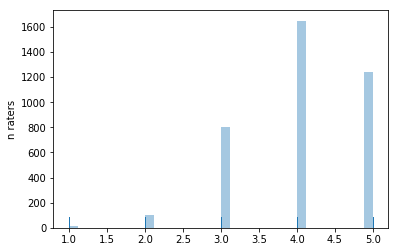

Miss Congeniality mean score is: 4.05


In [56]:
# how does it look like conditional on scoring high (4 or 5) on another movie?
def miss_cong_dist_cond_high(mov1, high_thresh = 4.0):
    mov1_id = movies.index[movies['title'] == mov1][0]
    mov1_scores = ratings.values[:, mov1_id]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        miss_cong_filtered = miss_cong_scores[mov1_scores >= high_thresh]
    sns.distplot(miss_cong_filtered, kde=False, rug=True)
    plt.ylabel('n raters')
    plt.show()
    print('Miss Congeniality mean score is: %.2f' % np.mean(miss_cong_filtered))
miss_cong_dist_cond_high('The Wedding Planner')

/home/jonathansomer/.virtualenvs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


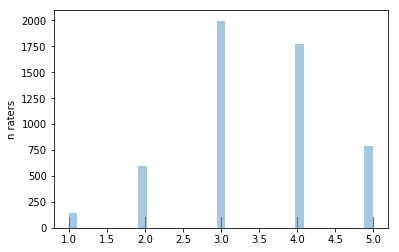

Miss Congeniality mean score is: 3.47


In [57]:
miss_cong_dist_cond_high('Pulp Fiction')

/home/jonathansomer/.virtualenvs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


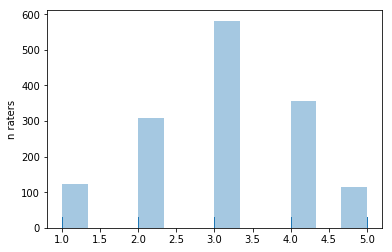

Miss Congeniality mean score is: 3.02


In [58]:
# how does it look like conditional on scoring low (1 or 2) on another movie?
def miss_cong_dist_cond_low(mov1, low_thresh = 2.0):
    mov1_id = movies.index[movies['title'] == mov1][0]
    mov1_scores = ratings.values[:, mov1_id]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        miss_cong_filtered = miss_cong_scores[mov1_scores <= low_thresh]
    sns.distplot(miss_cong_filtered, kde=False, rug=True)
    plt.ylabel('n raters')
    plt.show()
    print('Miss Congeniality mean score is: %.2f' % np.mean(miss_cong_filtered))
miss_cong_dist_cond_low('The Wedding Planner')

/home/jonathansomer/.virtualenvs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


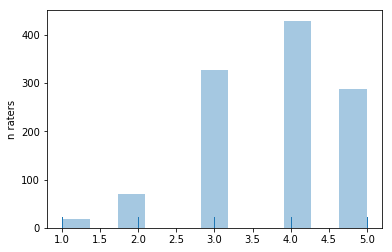

Miss Congeniality mean score is: 3.80


In [59]:
miss_cong_dist_cond_low('Pulp Fiction')

## Conditional on Missing Data Rate

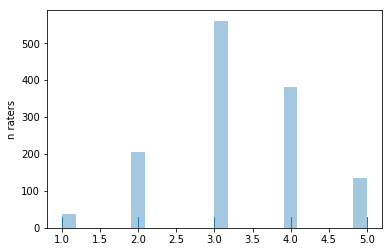

Miss Congeniality mean score is: 3.28


In [60]:
# how does it look like conditional on NOT scoring another movie (missing score)?
def miss_cong_dist_cond_missing(mov1):
    mov1_id = movies.index[movies['title'] == mov1][0]
    mov1_scores = ratings.values[:, mov1_id]
    mov1_na = np.isnan(mov1_scores)
    miss_cong_filtered = miss_cong_scores[mov1_na]
    sns.distplot(miss_cong_filtered, kde=False, rug=True)
    plt.ylabel('n raters')
    plt.show()
    print('Miss Congeniality mean score is: %.2f' % np.mean(miss_cong_filtered))
miss_cong_dist_cond_missing('The Wedding Planner')

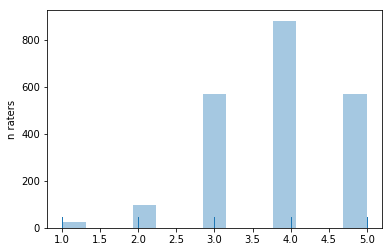

Miss Congeniality mean score is: 3.87


In [61]:
miss_cong_dist_cond_missing('Pulp Fiction')

## Advanced exploration: dimensionality reduction

### We have $n$ points in $p$ dimensions. In our case: $n=10^4, p=14$ (considering only the fully observed movies)
### We want to reduce the data to $q<<p$ dimensions (typically $q=2$ or $q=3$), to: 
* Identify **important dimensions** which summarize the data well
* **Visualize** the data (2-d or 3-d visualizations)
* Identify **structure** in the data, such as clusters

### Naive way: select $q$ out of the original $p$ dimensions
* For $q=2$, we have been looking at pairwise plots of movies

### Less Naive way: Look for interesting "projections": linear combinations of the variables which expose interesting information and patterns

## Mathematical setup

#### We have $n$ vectors in ${\mathbb R}^p$: $\mathbf{x}_1,..., \mathbf{x}_n$. 

#### We can desribe them thorugh a matrix $X_{n*p}$ (each row is an observation). 

#### Assume for simplicity that the columns are centered: $\sum_i x_{ij} = 0,\;\forall j$, so our data is a cloud around $0$ in ${\mathbb R}^p$.

#### Total dispersion (squared distance of points from their center): $\sum_{ij} x_{ij}^2 = \|\mathbf{x}_1\|_2^2+...+ \|\mathbf{x}_n\|_2^2 = tr (X^T X).$

#### Possible goal: find $q<<p$ **good directions**, such that **much of the dispersion** will be captured by these directions. 

#### A **direction** in ${\mathbb R}^p$ is a vector $\mathbf{v}\in {\mathbb R}^p$ with $\|\mathbf{v}\|_2^2=1$.




## The Principal Component Analysis (PCA) Problem

#### Goal: Find the $q$ direction(s) with the most dispersion

#### Projection in direction $\mathbf{v}$: $X\mathbf{v} \in \mathbb R^n.$ Examples: 
##### $\mathbf{v} = (1,0,...,0)^T$: pick first coordinate from each observation
##### $\mathbf{v} = (1/\sqrt{p},1/\sqrt{p},...,1/\sqrt{p})^T$: project on diagonal (average all coordinates)


#### Dispersion in direction $\mathbf{v}$: $\|X\mathbf{v}\|^2 = \mathbf{v}^T (X^TX) \mathbf{v}.$

#### Finding the best direction which maximizes dispersion: $ \mathbf{v}_1 = \arg\max_{\mathbf{v}:\|\mathbf{v}\|^2 =1} \|X\mathbf{v}\|^2 $

#### $\mathbf{v}_1$ is the first Principal Component direction: the best direction to project on!



## How do we find the next principal component? 

#### Now we want a **different** direction $\mathbf{v}_2$ which maximizes direction after accounting for $\mathbf{v}_1$.

#### Require orthogonality: $\mathbf{v}_2 = \arg\max_{\|\mathbf{v}\|^2 =1, \mathbf{v}^T\mathbf{v}_1 = 0}\|X\mathbf{v}\|^2 $

#### This is the second principal component

#### Can keep going looking for new directions


## PCA on the Netflix data

#### Our Netflix dataset contains the 1-5 rankings made by 10,000 users to 99 movies.

#### Let $X$ be the data matrix for the first 14 movies to which all users gave ranking.

#### So: $n = 10000$ and $p = 14$. This isn't that "Big", however even with 14 variables it is almost impossible to see any latent structure hidden in the data.

#### Let's perform PCA!

In [62]:
from sklearn.decomposition import PCA

# read in the data
X = ratings.values[:,:14]
#X = pd.read_table("http://www.tau.ac.il/~saharon/StatsLearn2018/train_ratings_all.dat",
#                  header = None, usecols = range(14)).values
print(X.shape)
print(X[:5, :5])

(10000, 14)
[[2. 4. 4. 4. 5.]
 [4. 5. 3. 3. 4.]
 [5. 5. 5. 5. 5.]
 [3. 3. 3. 4. 4.]
 [4. 4. 4. 5. 4.]]


In [63]:

# centering X: subtracting the mean from each column
X_centered = X - X.mean(axis = 0)

# instantiating PCA object
pca = PCA()

# performing PCA
pca.fit(X_centered)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [64]:
# What did we get?

# This is the W matrix, a.k.a the "loadings", a.k.a the matrix whose columns are XtX eigenvectors:
W = pca.components_
print(W.shape)

# Helper function for better pandas styling
def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

(14, 14)


In [65]:
# Let's see the W matrix first 3 eigenvectors alongside the movies: do you see anything interesting?
means = pd.DataFrame(X.mean(axis = 0))
means.columns = ['mean_rating']
loadings3 = pd.DataFrame(W.T[:, :3])
pd.concat([movies[:14]['title'], means, loadings3], axis = 1).set_index('title').style.applymap(color_negative_red).format("{:.2f}")

,mean_rating,0,1,2
title,,,,
Independence Day,4.15,-0.25,-0.26,0.14
The Patriot,4.11,-0.26,-0.06,-0.41
The Day After Tomorrow,3.70,-0.32,-0.15,0.05
Pirates of the Caribbean: The Curse of the Black Pearl,4.35,-0.15,-0.03,0.21
Pretty Woman,4.07,-0.23,0.45,0.24
Forrest Gump,4.51,-0.11,0.01,-0.08
The Green Mile,4.46,-0.16,0.00,-0.16
Con Air,3.73,-0.30,-0.32,0.20
Twister,3.75,-0.30,-0.14,0.22


(10000, 14)


/home/jonathansomer/.virtualenvs/ml/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


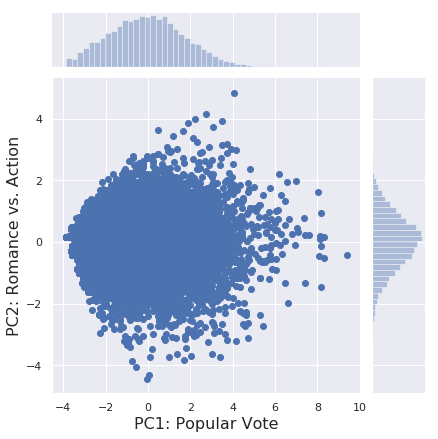

In [66]:
# And these are our principal components, the T matrix:
T = np.matmul(X_centered, W.T) # make sure this is the same as pca.transform(X_centered)
print(T.shape)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# The first PC will indicate to what extent the user conforms with the general popular vote of movies:
# The second PC will indicate if the user is a romance-comedy-drama or action person:
# Are there interesting clusters or people worth pointing at? Would have been nice to see users' gender here!
ax = sns.jointplot(T[:,0], T[:,1])
ax.set_axis_labels('PC1: Popular Vote', 'PC2: Romance vs. Action', fontsize=16)
plt.show()

In [67]:
# And now: Miss Congeniality!

# What do you expect the scores to be for users that are high on 1st PC (hate all films)?
PC1_top_100 = T[:, 0].argsort()[-100:]
print('Top PC1:',miss_cong.iloc[PC1_top_100, :].groupby('score').size())
# What do you expect the scores to be for users that are low on 1st PC (love all films)
PC1_bottom_100 = T[:, 0].argsort()[:100]
print('Bottom PC1:', miss_cong.iloc[PC1_bottom_100, :].groupby('score').size())

Top PC1: score
1    30
2    32
3    30
4     8
dtype: int64
Bottom PC1: score
3     5
4    16
5    79
dtype: int64


In [68]:

# What do you expect the scores to be for users that are high on 2nd PC (like romantic films)?
PC2_top_100 = T[:, 1].argsort()[-100:]
print('Top PC2:',miss_cong.iloc[PC2_top_100, :].groupby('score').size())
# What do you expect the scores to be for users that are low on 2nd PC (like action films)
PC2_bottom_100 = T[:, 1].argsort()[:100]
print('Bottom PC2:', miss_cong.iloc[PC2_bottom_100, :].groupby('score').size())

Top PC2: score
2    12
3    26
4    28
5    34
dtype: int64
Bottom PC2: score
1    17
2    27
3    35
4    12
5     9
dtype: int64


## Calculating Principal Components: the SVD

#### We have the matrix $X_{n*p}$ and want to find: $$\mathbf{v}_1 = \arg\max_{\mathbf{v}:\|\mathbf{v}\|^2 =1} \|X\mathbf{v}\|^2$$ 
$$\mathbf{v}_2 = \arg\max_{\mathbf{v}:\|\mathbf{v}\|^2 =1, \mathbf{v}^T\mathbf{v}_1 = 0}\|X\mathbf{v}\|^2$$ 
Etc. 

#### The key: the Singular value decomposition (SVD) $X = U D V^T$, where: 
#### $U_{n*p}$ is a matrix with orthonormal columns: $U^TU = I_{p*p}$<br>$D_{p*p}$ is a diagonal matrix with non-negative diagonal elements  (called the Singular Values)<br>  $V_{p*p}$ is an orthogonal matrix: its columns are an orthonormal basis of $\mathbb R^p$, $V^TV = V V^T = I$. 



## More on the SVD

($X = U D V^T$, where:<br> 
$U_{n*p}$ is a matrix with orthonormal columns<br>  $D_{p*p}$ is a diagonal matrix with non-negative diagonal elements  (called the Singular Values)<br>  $V_{p*p}$ is an orthogonal matrix: its columns are an orthonormal basis of $\mathbb R^p$.) 

#### Assuming $d_1>d_2>...d_p$ on the diagonal of $D$ defines this decomposition uniquely.

#### Now denote the columns of $V=[\mathbf{v}_1,...\mathbf{v}_p]$, a basis of $\mathbb R^p$, and the columns of $U=[\mathbf{u}_1,...\mathbf{u}_p]$.

#### Key observation: $X\mathbf{v}_j = U D V^T \mathbf{v}_j = UD \mathbf{e}_j = \mathbf{u}_j d_j$ because of orthogonality of $V$



## Using the SVD to find the PCA

#### Given a vector $\mathbf{v} \in \mathbb R^p$ with $\|\mathbf{v}\|^2=1$, express it in the $V$ columns basis: <br>$ \mathbf{v} = a_1\mathbf{v}_1+...+a_p \mathbf{v}_p \mbox{ with } a_1^2+...+a_p^2 = 1.$

#### Now we can calculate its dispersion using the SVD: <br>$ X\mathbf{v} = a_1 d_1 \mathbf{u}_1 + ... + a_p d_p \mathbf{u}_p \Rightarrow \|X\mathbf{v}\|^2 = a_1^2 d_1^2 +... + a_p^2 d_p ^2$.


#### We know $a_1^2+...+a_p^2=1$, hence: $ \|X\mathbf{v}\|^2 \leq d_1^2.$

#### But we get equality when $\mathbf{v}=\mathbf{v}_1$, the first column of $V$, hence $\mathbf{v}_1$ is the first PC

#### Similarly the second PC is defined by $\mathbf{v}_2$ in $V$, and so on